In [151]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1 - Prepare data

In [152]:
# 2)
# Charger les données
df = pd.read_csv(
    r"C:\Users\harri\ai_bobby_repository\data\raw\Hardness.csv", sep=";",
    dtype={
        'Treatment code': object,
        'Protein codes': object,
        'Type of salt': object,
    }
)

# Nettoyer les noms de colonnes (supprimer espaces, caractères invisibles)
df.columns = df.columns.str.strip()

# Afficher la liste des colonnes pour vérifier leur existence
print("Colonnes disponibles :", df.columns.tolist())

# Définir les colonnes catégoriques
categorical_columns = ['Protein codes', 'Type of salt', 'Additives', 'Treatment code']

# Définir les colonnes numériques
numerical_columns = [
    'Samples stored (°C)',
    'ionic strength (M)',
    'Additives Concentration (%)',
    'Protein Concentration (%)',
    'pH',
    'Heating temperature (°C) for gel preparation',
    'Heating/hold time (min)',
    'Hardness/firmness/strength (g)',
]

# Convertir les colonnes catégoriques en chaînes de caractères
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('str')
    else:
        print(f"Attention : La colonne '{col}' est absente du DataFrame.")

# Remplacer les virgules par des points et convertir les colonnes numériques en float
for col in numerical_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].replace(',', '.', regex=True), errors='coerce')
    else:
        print(f"Attention : La colonne '{col}' est absente du DataFrame.")

# Vérifier si certaines colonnes contiennent encore des valeurs manquantes après conversion
missing_values = df[numerical_columns].isna().sum()
print("Valeurs manquantes par colonne :", missing_values)

# Colonnes à supprimer
columns_to_drop = [
    'Citation',
    'Citation Link',
    'Protein',
    'Treatment condition code',
    'Treatment condition value',
    'Treatment temperature ( °C)',
    'Treatment time (min)',
    'Storage time (h)',
    'If a gel can be formed (0-1)',
]

# Supprimer les colonnes si elles existent
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_clean_copy = df.drop(columns=columns_to_drop, axis=1)

# Supprimer les lignes avec des valeurs cibles manquantes
df_clean_copy = df_clean_copy.dropna(subset=['Hardness/firmness/strength (g)'])

# Afficher un aperçu des données finales
df_clean_copy.info()

Colonnes disponibles : ['Citation', 'Citation Link', 'Protein', 'Protein codes', 'Protein Concentration (%)', 'Treatment code', 'Treatment condition code', 'Treatment condition value', 'Treatment temperature ( °C)', 'Treatment time (min)', 'Additives', 'Additives Concentration (%)', 'pH', 'Type of salt', 'ionic strength (M)', 'Heating temperature (°C) for gel preparation', 'Heating/hold time (min)', 'Samples stored (°C)', 'Storage time (h)', 'If a gel can be formed (0-1)', 'Hardness/firmness/strength (g)', 'Unnamed: 21']
Valeurs manquantes par colonne : Samples stored (°C)                             105
ionic strength (M)                              515
Additives Concentration (%)                     412
Protein Concentration (%)                         0
pH                                              207
Heating temperature (°C) for gel preparation    169
Heating/hold time (min)                         169
Hardness/firmness/strength (g)                    0
dtype: int64
<class 'pan

## Deleting outlier data

In [153]:
import pandas as pd

# Sélectionner uniquement les colonnes numériques
df_clean_copy_numeric = df_clean_copy.copy().select_dtypes(include=[float, int])

# Calcul des quartiles et de l'IQR (Interquartile Range)
Q1 = df_clean_copy_numeric.quantile(0.25)
Q3 = df_clean_copy_numeric.quantile(0.75)
IQR = Q3 - Q1

# Définir les limites pour considérer un outlier comme étant hors de l'intervalle [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les données pour ne garder que celles sans outliers
df_clean_no_outliers = df_clean_copy_numeric[~((df_clean_copy_numeric < lower_bound) | (df_clean_copy_numeric > upper_bound)).any(axis=1)]

# Afficher la taille avant et après suppression des outliers
print(f"Before Deleting : {df_clean_copy.shape}")
print(f"After Deleting : {df_clean_no_outliers.shape}")


Before Deleting : (1074, 13)
After Deleting : (468, 8)


In [154]:
df_clean_copy['Hardness/firmness/strength (g)'].unique()

array([1.3191000e+02, 1.5591000e+02, 1.5114000e+02, 1.4484000e+02,
       9.5710000e+01, 1.0743000e+02, 1.0945000e+02, 1.1866000e+02,
       2.9450000e+01, 4.6340000e+01, 5.8380000e+01, 9.7650000e+01,
       6.0648000e+02, 0.0000000e+00, 4.6178000e+02, 5.4595000e+02,
       6.2205000e+02, 1.9309500e+03, 1.2024400e+03, 1.2595000e+02,
       2.5182000e+02, 3.1956000e+02, 1.9578200e+03, 1.1726600e+03,
       1.0910800e+03, 1.6519100e+03, 1.3562000e+03, 1.5601400e+03,
       1.8762500e+03, 7.7600000e+01, 9.5440000e+01, 1.4276000e+02,
       1.8355000e+02, 6.0060000e+01, 7.2400000e+01, 4.7416000e+02,
       6.8116000e+02, 7.6070000e+02, 1.1196000e+02, 4.2623000e+02,
       6.5771000e+02, 1.0808800e+03, 1.6305000e+03, 5.1490000e+01,
       5.3840000e+02, 8.5451000e+02, 1.0166400e+03, 1.3755800e+03,
       1.6927000e+02, 1.3092900e+03, 1.7141200e+03, 2.2698500e+03,
       2.6440800e+03, 1.0520240e+04, 1.2953250e+04, 1.5610590e+04,
       1.2594310e+04, 1.3462080e+04, 1.7690780e+04, 1.7337960e

In [5]:
def train_and_evaluate_model(X, y, k=5, model=Pipeline(steps=[]), 
                            metrics_list=[mean_absolute_error, mean_squared_error], 
                            numerical_cols=None, categorical_cols=None):
  """
  Trains and evaluates a regression model using K-fold cross-validation.

  Args:
    X: The feature matrix.
    y: The target variable.
    k: The number of folds for cross-validation.
    model: The regression model to use (must be a Pipeline if preprocessing is needed).
    metrics_list: A list of metric functions to evaluate the model.
    numerical_cols: List of numerical column names (needed for preprocessing).
    categorical_cols: List of categorical column names (needed for preprocessing).

  Returns:
    A dictionary of evaluation results for each fold and the average across all folds.
  """

  kf = KFold(n_splits=k, shuffle=True, random_state=42)
  results = []

  for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_df = pd.DataFrame(X_train, columns=numerical_cols.tolist() + categorical_cols.tolist())
    X_test_df = pd.DataFrame(X_test, columns=numerical_cols.tolist() + categorical_cols.tolist())
    model.fit(X_train_df, y_train)  # Fit with DataFrame
    y_pred = model.predict(X_test_df)  # Predict with DataFrame

    fold_results = {}
    for metric in metrics_list:
      metric_name = metric.__name__
      fold_results[metric_name] = metric(y_test, y_pred)
    results.append(fold_results)

  # Calculate average results across all folds
  avg_results = {}
  for metric_name in results[0].keys():
    avg_results[metric_name] = np.mean([fold[metric_name] for fold in results])

  return avg_results

In [155]:
X = df_clean_copy.drop('Hardness/firmness/strength (g)', axis=1)
y = df_clean_copy['Hardness/firmness/strength (g)']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['category']).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

## 2 - Train models

In [26]:
'''from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# 2. Séparation des données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    
}'''

'from sklearn.pipeline import Pipeline\nfrom sklearn.linear_model import SGDRegressor, ElasticNet\nfrom sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor\nfrom sklearn.svm import LinearSVR\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\n\n\n# 2. Séparation des données en jeu d\'entraînement et de test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n\nmodels = {\n    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),\n    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),\n    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),\n    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),\n    "LinearSVR": LinearSVR(random_state=42),\n    "KNeighbors": KNeighborsRegressor(n_neighbors=5),\n    "RandomForest": RandomFor

In [156]:
# 5. Data separation into training and test sets (80% Train and 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Fitting du preprocessor uniquement sur X_train
preprocessor.fit(X_train)

# 7. Transformation de X_train et X_test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 8. Initializing models
models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
}

In [157]:
# 9. Entraînement et évaluation des modèles
results = []

for name, model in models.items():
    # Création d'un pipeline avec le modèle
    pipeline = Pipeline([
        ("model", model)
    ])
    
    # Entraînement
    pipeline.fit(X_train_processed, y_train)
    
    # Prédictions
    y_pred = pipeline.predict(X_test_processed)
    
    # Calcul des métriques
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Stockage des résultats
    results.append({"Modèle": name, "R²": r2, "MAE": mae, "MSE": mse})

# 10. Affichage des résultats sous forme de DataFrame
df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)
df_results

,Modèle,R²,MAE,MSE
6,RandomForest,0.990313,396.636506,1.470309e+06
2,GradientBoosting,0.989115,609.887296,1.652244e+06
5,KNeighbors,0.987874,492.596810,1.840536e+06
3,AdaBoost,0.981981,703.392829,2.735049e+06
0,SGDRegressor,0.459088,3542.080557,8.210183e+07
1,ElasticNet,0.454888,3313.960359,8.273938e+07
4,LinearSVR,-0.013905,1697.242712,1.538947e+08


In [158]:
df_clean_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 13 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Protein codes                                 1074 non-null   object 
 1   Protein Concentration (%)                     1074 non-null   float64
 2   Treatment code                                1074 non-null   object 
 3   Additives                                     1074 non-null   object 
 4   Additives Concentration (%)                   662 non-null    float64
 5   pH                                            867 non-null    float64
 6   Type of salt                                  1074 non-null   object 
 7   ionic strength (M)                            559 non-null    float64
 8   Heating temperature (°C) for gel preparation  905 non-null    float64
 9   Heating/hold time (min)                       905 non-null    f

<Figure size 500x500 with 0 Axes>

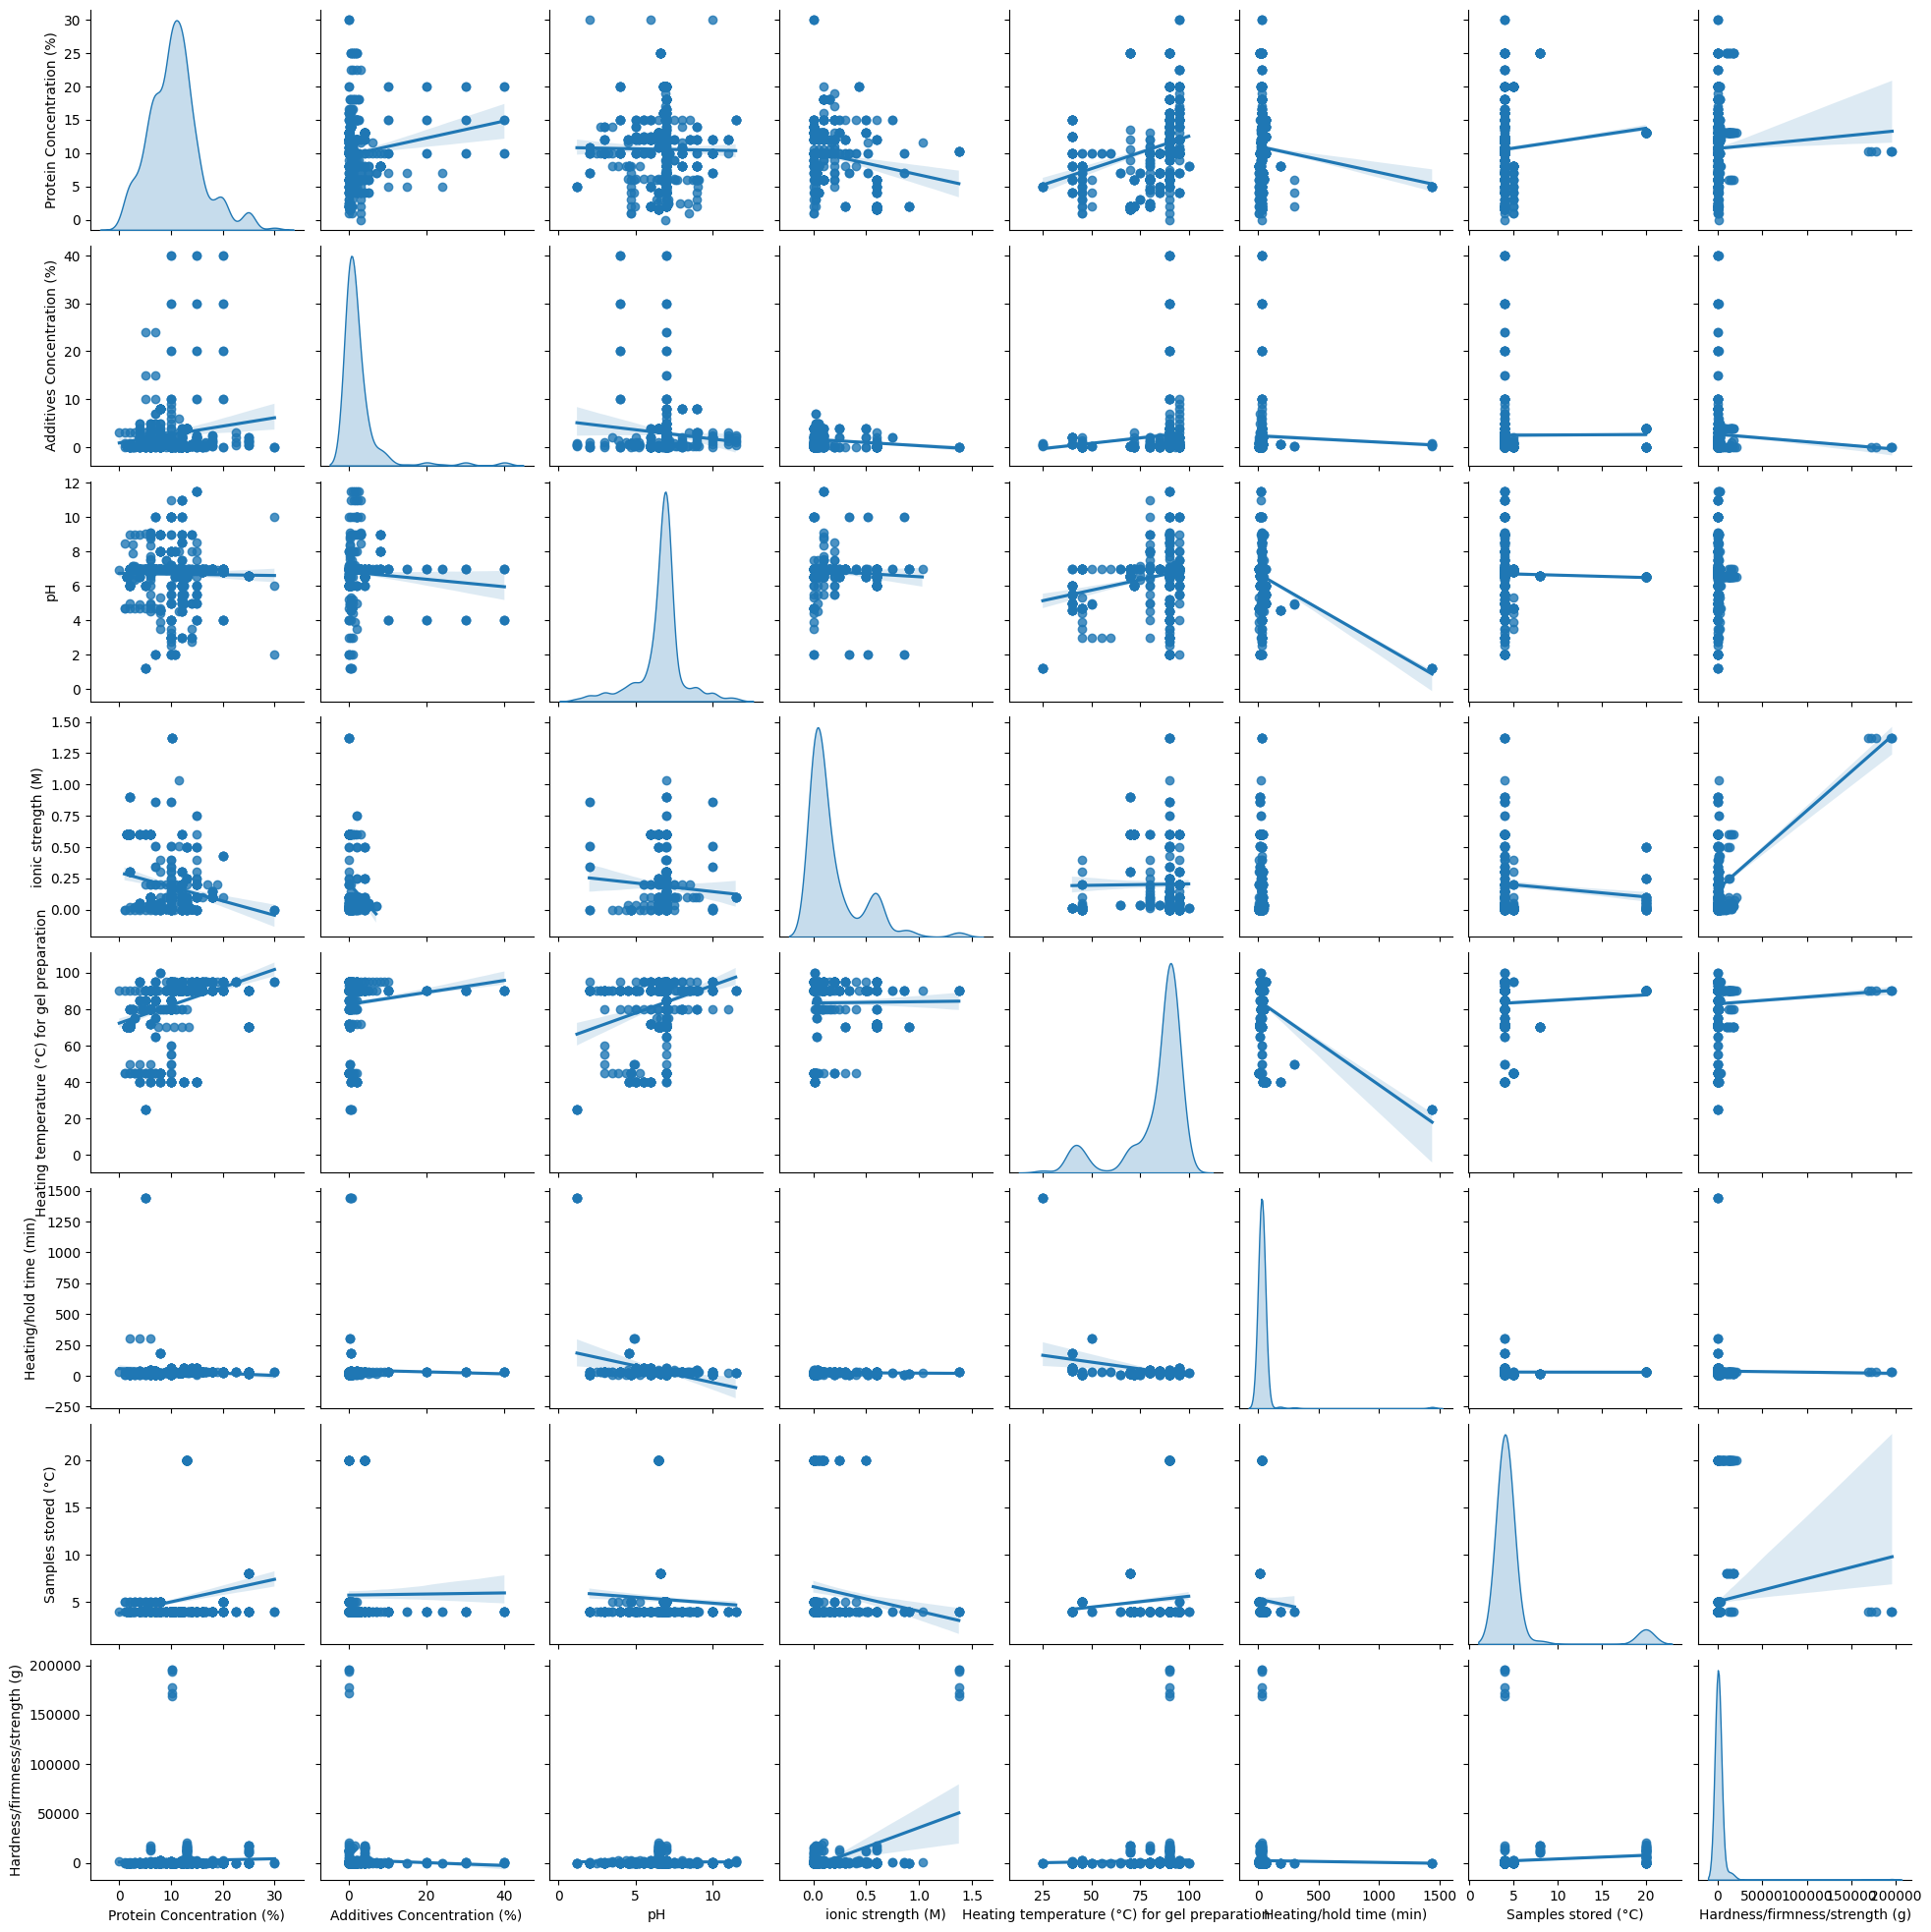

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(5,5))
sns.pairplot(data= df_clean_copy, kind= 'reg', diag_kind= 'kde' )
plt.show()

## First training of Random Forest with outlier data

In [159]:
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

# Créer et entraîner le modèle CatBoost avec les données transformées
regression_lineaire = RandomForestRegressor(n_estimators=100, random_state=42) # Désactiver les logs pour un affichage propre
regression_lineaire.fit(X_train_processed, y_train)


RandomForestRegressor(random_state=42)

R² Score: 0.9903


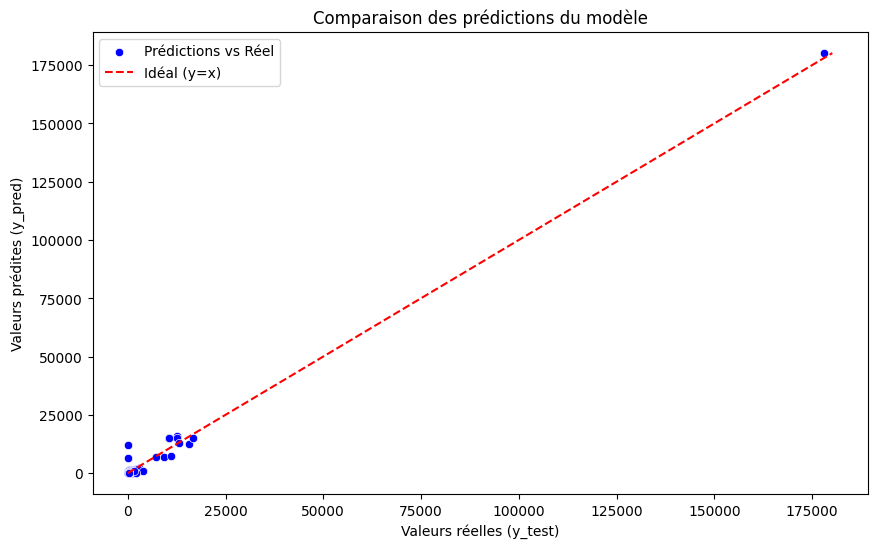

In [160]:
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions du modèle
y_pred = regression_lineaire.predict(X_test_processed)

# Calcul du score R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Tracer le graphique de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=y_test,  
    y=y_pred,  
    color='blue',  
    label='Prédictions vs Réel'
)

# Ajouter une ligne de régression idéale (y = x) pour comparaison
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label="Idéal (y=x)")

# Labels et titre
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_pred)")
plt.title("Comparaison des prédictions du modèle")
plt.legend()
plt.show()


In [161]:
# Créer une copie de X_test pour éviter les modifications non voulues
X_test_results = X_test.copy()

# Ajouter les colonnes de labels réels et prédits
X_test_results['True label'] = y_test
X_test_results['Predict Label'] = y_pred

tol = 0.3 # Tolérance de 30%
correct_predictions = X_test_results[np.abs(X_test_results['True label'] - X_test_results['Predict Label']) < tol]

# Afficher un échantillon
correct_predictions.sample(min(11, len(correct_predictions)))

,Protein codes,Protein Concentration (%),Treatment code,Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Unnamed: 21,True label,Predict Label
538,30105,12.0,nan,90404,0.10,5.2,nan,NaN,90.0,30.0,4.0,NaN,108.86,108.869915
611,10301,12.0,30602,70103,2.98,10.0,nan,NaN,NaN,NaN,4.0,NaN,21.85,21.966800
10,10501,12.0,nan,80203,1.00,7.0,nan,NaN,90.0,30.0,4.0,NaN,58.38,58.270650


## Check the homoscedasticity of the residuals and the distribution of the residuals

✔ If the residuals (errors between prediction and true value) are randomly distributed around zero (without any obvious structure), this means that the homoscedasticity assumption is met.

❌ If a particular shape appears (e.g. open or closed cone), this indicates heteroscedasticity, which can distort predictions and require data transformation.

✔ If the residuals have a bell-shaped (Gaussian) distribution, then the normality hypothesis is respected.

❌ If the residuals are asymmetric or have extreme values ​​(thick tails), this may indicate the presence of outliers or the need for a data transformation (e.g. logarithmic).

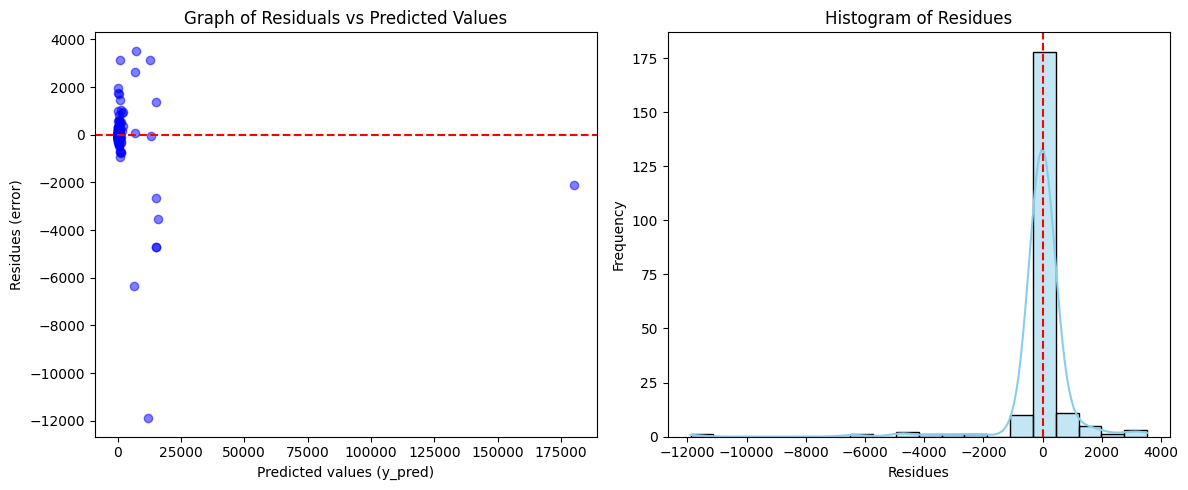

Skewness : -5.2526
Kurtosis : 46.2176


In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Calculation of residuals
residuals = y_test - y_pred

# Creating a single figure with 2 sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#1st Graph: Plot of residuals vs predicted values
axes[0].scatter(y_pred, residuals, color="blue", alpha=0.5)
axes[0].axhline(y=0, color="red", linestyle="dashed")  # Ligne horizontale à 0
axes[0].set_xlabel("Predicted values ​​(y_pred)")
axes[0].set_ylabel("Residues (error)")
axes[0].set_title("Graph of Residuals vs Predicted Values")

#2nd Graph: Histogram of residuals
sns.histplot(residuals, bins=20, kde=True, color="skyblue", edgecolor="black", ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='dashed')  # Ligne centrale
axes[1].set_title("Histogram of Residues")
axes[1].set_xlabel("Residues")
axes[1].set_ylabel("Frequency")

# Display
plt.tight_layout()
plt.show()

print(f"Skewness : {stats.skew(residuals):.4f}")
print(f"Kurtosis : {stats.kurtosis(residuals):.4f}")


In [13]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")

if p_value > 0.05:
    print("The residuals follow a normal distribution (normality hypothesis accepted).")
else:
    print("The residuals do not follow a normal distribution (normality hypothesis rejected).")


Shapiro-Wilk test p-value: 0.0000
The residuals do not follow a normal distribution (normality hypothesis rejected).


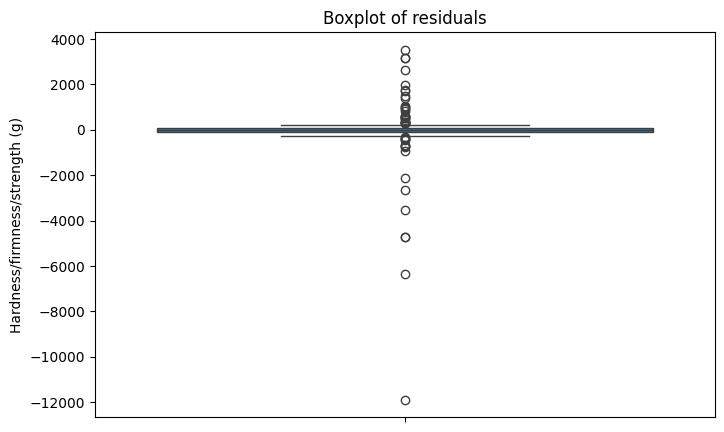

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=residuals)
plt.title("Boxplot of residuals")
plt.show()


## Applying logarithmic transformation to reduce the impact of outlier data

In [171]:
import numpy as np
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor


# Transformation logarithmique de la variable cible
y_train_log = np.log1p(y_train)  # log(1 + y) pour éviter log(0)
y_test_log = np.log1p(y_test)

# Créer et entraîner le modèle CatBoost avec les données transformées
regression_lineaire = RandomForestRegressor(verbose=0)  # Désactiver les logs pour un affichage propre
regression_lineaire.fit(X_train_processed, y_train_log)

# Prédictions avec le modèle entraîné
y_pred_log = regression_lineaire.predict(X_test_processed)

# Reconvertir les prédictions à l'échelle originale
y_pred = np.expm1(y_pred_log)  # Annule la transformation logarithmique

## CROSS VALIDATION ON 5-KFOLD

In [172]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Définir la validation croisée (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Appliquer la validation croisée avec R² comme métrique
scores = cross_val_score(regression_lineaire, X_train_processed, y_train, cv=cv, scoring='r2')

# Afficher les résultats
print(f"Scores de chaque fold: {scores}")
print(f"R² moyen: {np.mean(scores):.4f}")
print(f"Écart-type des scores: {np.std(scores):.4f}")


Scores de chaque fold: [0.97506557 0.9909386  0.99466122 0.75411437 0.99367011]
R² moyen: 0.9417
Écart-type des scores: 0.0941


R² Score: 0.9832


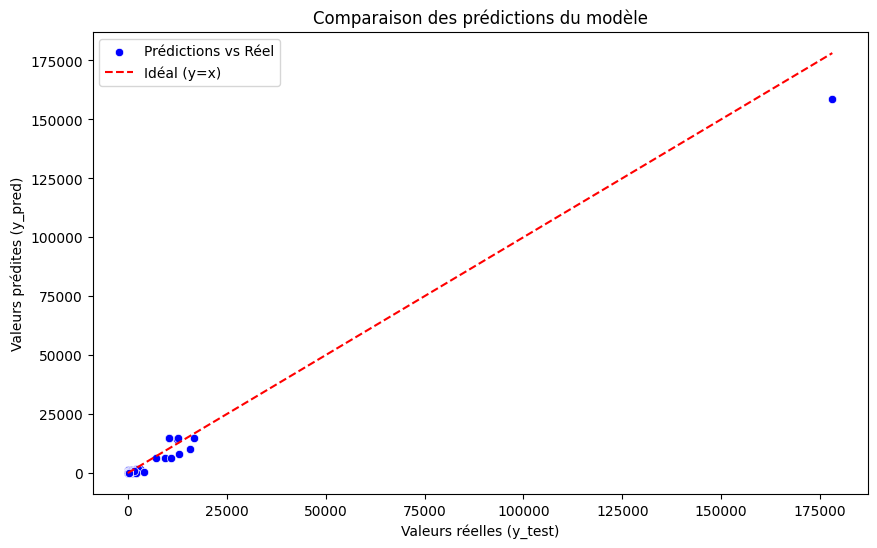

In [173]:
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Calcul du score R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Tracer le graphique de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=y_test,  
    y=y_pred,  
    color='blue',  
    label='Prédictions vs Réel'
)

# Ajouter une ligne de régression idéale (y = x) pour comparaison
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label="Idéal (y=x)")

# Labels et titre
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_pred)")
plt.title("Comparaison des prédictions du modèle")
plt.legend()
plt.show()


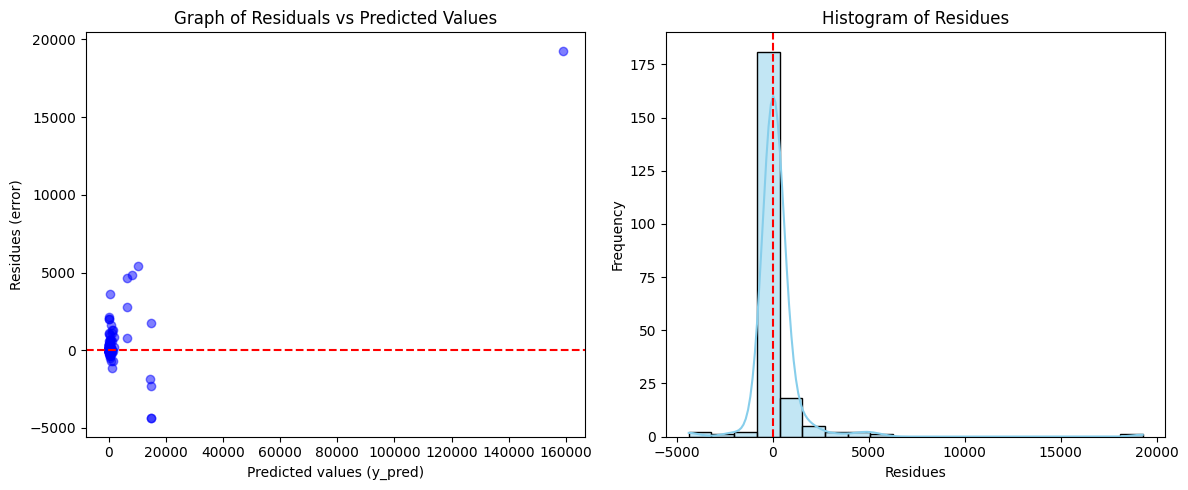

Skewness : 8.3347
Kurtosis : 96.8698


In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Calculation of residuals
residuals = y_test - y_pred

# Creating a single figure with 2 sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#1st Graph: Plot of residuals vs predicted values
axes[0].scatter(y_pred, residuals, color="blue", alpha=0.5)
axes[0].axhline(y=0, color="red", linestyle="dashed")  # Ligne horizontale à 0
axes[0].set_xlabel("Predicted values ​​(y_pred)")
axes[0].set_ylabel("Residues (error)")
axes[0].set_title("Graph of Residuals vs Predicted Values")

#2nd Graph: Histogram of residuals
sns.histplot(residuals, bins=20, kde=True, color="skyblue", edgecolor="black", ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='dashed')  # Ligne centrale
axes[1].set_title("Histogram of Residues")
axes[1].set_xlabel("Residues")
axes[1].set_ylabel("Frequency")

# Display
plt.tight_layout()
plt.show()

print(f"Skewness : {stats.skew(residuals):.4f}")
print(f"Kurtosis : {stats.kurtosis(residuals):.4f}")


## 3 - Get feature importance for CatBoost Model (best model)

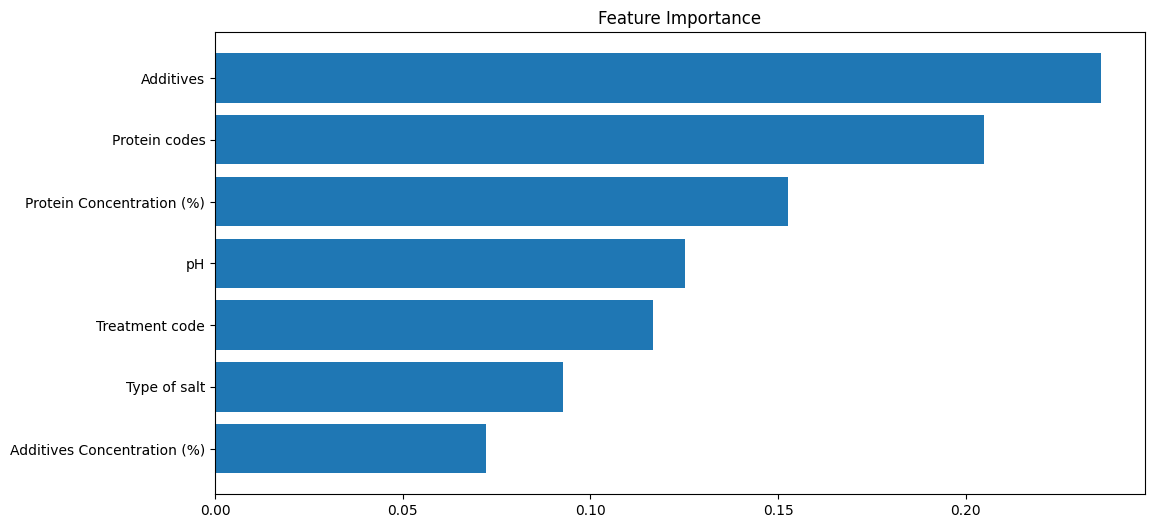

In [111]:
from matplotlib import pyplot as plt

feature_importance = regression_lineaire.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [31]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(regression_lineaire, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

c:\Users\harri\anaconda3\envs\notebook\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


ValueError: X has 12 features, but RandomForestRegressor is expecting 7 features as input.

### Explanation using SHAP values

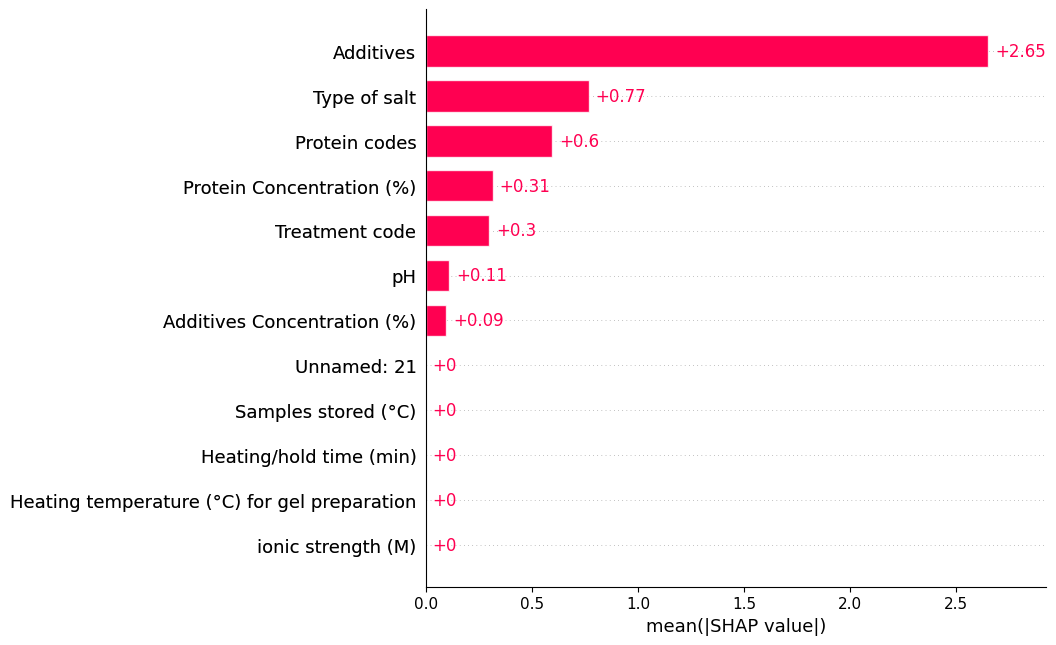

In [32]:
import shap
explainer = shap.TreeExplainer(regression_lineaire)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=X_test.shape[0])

### Explanation for Technical Audience (Data Scientists):
This SHAP summary plot shows the average magnitude of SHAP values for features used in a **CatBoostRegressor model**. The SHAP value for each feature represents its contribution to the model's predictions. The features are ranked in descending order of importance based on their mean absolute SHAP values. 

- **"Ionic strength (M)"** has the highest importance, indicating it significantly impacts the model's predictions.
- Features like **"Samples stored (°C)"** and **"Type of salt"** also play crucial roles but are less influential compared to "Ionic strength."
- Features such as **"Additives"** and **"Protein codes"** have much smaller SHAP values, implying they contribute less to the prediction.

The results can guide feature engineering and domain understanding by highlighting which variables are driving the predictions.

---

### Explanation for Non-Technical Stakeholders:
This plot helps us understand which factors are most important for the predictions made by the model. Each bar represents how much a specific factor (like **"Ionic strength"** or **"Samples stored temperature"**) influences the model's outcomes on average.

- The top factor, **"Ionic strength"**, has the biggest influence, meaning it strongly affects how the predictions change.
- Factors like the **"storage temperature"** and the **"type of salt"** are also quite important, but less so than ionic strength.
- Factors lower down, like **"Additives"**, have very little impact on the model's predictions.

This information can help focus on the most critical factors for decision-making or further experimentation.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0, ...])

In [30]:
shap.initjs()
shap.plots.force(shap_values[11, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Using DiCE library for counterfactual explanations

In [40]:
import dice_ml
from dice_ml import Dice

d_gel = dice_ml.Data(dataframe=df_clean,
                      continuous_features=list(numerical_cols),
                      outcome_name='Hardness/firmness/strength (g)')

# We provide the type of model as a parameter (model_type)
catboost_with_preprocessing = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
catboost_with_preprocessing.fit(X_train, y_train)
m_gel = dice_ml.Model(model=catboost_with_preprocessing, backend="sklearn", model_type='regressor')
exp_genetic_gel = Dice(d_gel, m_gel, method="genetic")

In [45]:
# Multiple queries can be given as input at once
# query_instances_gel = X_test[20:22]
# genetic_gel = exp_genetic_gel.generate_counterfactuals(
#     query_instances_gel,
#     total_CFs=2,
#     desired_range=[100, 500])
# genetic_gel.visualize_as_dataframe(show_only_changes=True)